# FSPS Examples for AST2040

Documentation for the Python FSPS bindings is here: 

http://dfm.io/python-fsps/current/stellarpop_api/#api-reference

To use the Python bindings you first need to install Charlie Conroy's Flexible Stellar Population Synthsis (FSPS) Fortran code, which you can find here:

https://github.com/cconroy20/fsps

These are the papers which describe FSPS:

- Conroy, Gunn, & White 2009, ApJ, 699, 486
- Conroy & Gunn 2010, ApJ, 712, 833


Do stuff beyond what Bob asks for to impress him

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
os.environ["SPS_HOME"] = "/Users/nasserm/Documents/vscode/extragalactic/fsps"
import fsps
import pandas as pd

plt.rcParams['figure.dpi']= 100
# plt.style.use('sm.mplstyle')  # Removed custom style since it is not available.
plt.style.use('dark_background')

Let's model the simplest possible galaxy: a simple stellar population (basically, a gigantic globular cluster). This thing has a star formation history that is a delta function... all the stars form in a single burst. This is totally unrealistic of course but it's useful reference case. You should play with other star-formation histories on your own!

In [155]:
%%time
sp = fsps.StellarPopulation(compute_vega_mags=False, 
                            zcontinuous=1, #continuous star formation history, I want exponential. Burst is zcontinous = 0
                            sfh=0, 
                            logzsol=0.0, 
                            dust_type=2, 
                            dust2=0.2)


CPU times: user 81 μs, sys: 50 μs, total: 131 μs
Wall time: 135 μs


Now define the filter set we want to use. We'll use the Sloan Survey filter set as it's such a common filter set these days, it's almost a universal standard for visible-wavelength telescopes.

In [156]:
%%time
sdss_bands = fsps.find_filter('sdss') #we're actually using JWST filters not sloan
jwst_bands = ['jwst_f200w', 'jwst_f444w']
crazy_bands = ['sdss_g', 'jwst_f200w', 'jwst_f444w']
print(sdss_bands) 

['sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z']
CPU times: user 70 μs, sys: 15 μs, total: 85 μs
Wall time: 88 μs


The first call to `get_mags()` will take a long time, as the module is calculating everything for everything! Once it has done that the results are stored in the object though.

In [157]:
%%time
result = sp.get_mags(bands=crazy_bands)

CPU times: user 21.1 s, sys: 99.4 ms, total: 21.2 s
Wall time: 21.2 s


Subsequent calls to `get_mags()` are very quick.

In [165]:
%%time
sp.get_mags(tage=0.06, redshift=10, bands=crazy_bands) ### 1 GYr at a red shift of 1

CPU times: user 12.3 ms, sys: 1.38 ms, total: 13.7 ms
Wall time: 13.8 ms


array([83.44859761, 51.18655675, 50.35378819])

Remember that the modelled stellar population has a mass of 1 solar mass! So you need to multiply it by the mass you want. If you're working in mag units, you need to subtract off 2.5*log10(mass in solar units).

In [166]:
%%time
-2.5*math.log10(10**7) + sp.get_mags(tage=.06, # + give the offset given in the homework question
                                        redshift=10, 
                                        bands=crazy_bands)

CPU times: user 12.2 ms, sys: 527 μs, total: 12.7 ms
Wall time: 13.3 ms


array([65.94859761, 33.68655675, 32.85378819])

The `sp` object stores complete spectra!

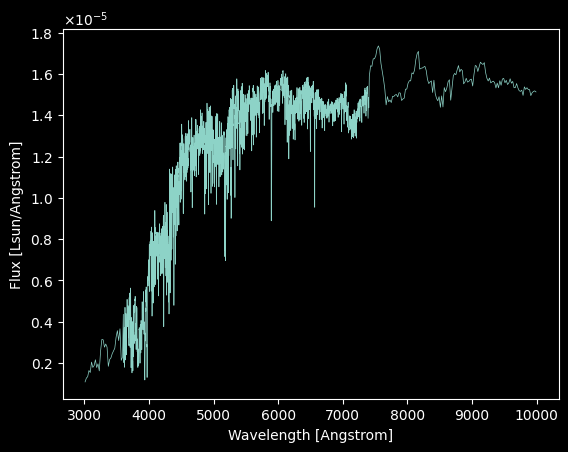

CPU times: user 76.2 ms, sys: 12.5 ms, total: 88.7 ms
Wall time: 88.5 ms


In [164]:
%%time

wave, spec = sp.get_spectrum(tage=13.5, peraa=True);

# Plot the spectrum in the range 3000A to 10,000A
idx_low = np.searchsorted(wave, 3000, side="left");
idx_high = np.searchsorted(wave, 10000, side="left");
xdata = wave[idx_low:idx_high]
ydata = spec[idx_low:idx_high]

plt.plot(xdata, ydata, linewidth=0.5);
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux [Lsun/Angstrom]")
ax = plt.gca()
ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax.yaxis.major.formatter._useMathText = True
plt.show()

## A cosmologically consistent galaxy (sort-of)

Let's assume our toy galaxy is born at z=5. How old was the Universe?

In [10]:
from astropy.cosmology import WMAP9 as cosmo

age_of_universe_when_galaxy_was_born = cosmo.age(5)
age_of_universe_when_galaxy_was_born

<Quantity 1.19002429 Gyr>

To get the age of the galaxy, we just just get the age of the Universe at a given redshift and subtract off the time at which the galaxy was born. 

In [11]:
redshifts = np.arange(0.1,5,0.2)
redshifts

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9])

In [12]:
age_of_galaxy = cosmo.age(redshifts) - age_of_universe_when_galaxy_was_born
age_of_galaxy

<Quantity [11.26351772,  9.11736687,  7.46661185,  6.17937037,  5.16178366,
            4.3463132 ,  3.68407837,  3.13946301,  2.68628373,  2.30508575,
            1.9812448 ,  1.70363532,  1.46369232,  1.25474568,  1.07154362,
            0.9099079 ,  0.76648183,  0.63854396,  0.523869  ,  0.42062274,
            0.32728213,  0.24257359,  0.16542528,  0.09492959,  0.03031365] Gyr>

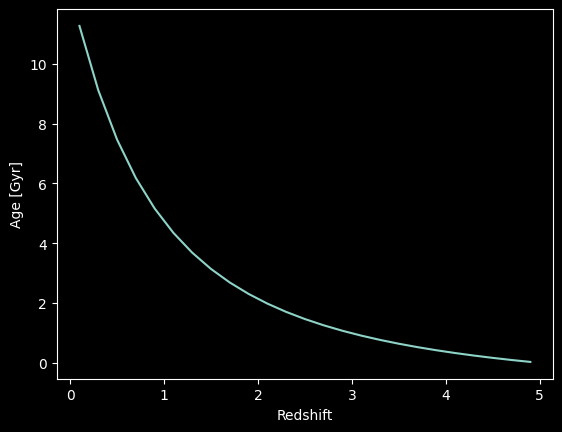

In [13]:
plt.plot(redshifts,age_of_galaxy)
plt.xlabel("Redshift")
plt.ylabel("Age [Gyr]");

So now the hard work is done and we can work the galaxy magnitudes out in a nicely self-consistent way.

In [14]:
logmass_of_galaxy = 10.4

# Define the dataframe structure and create a template.
col = {'Redshift': [], 'Age': [], 'sdss_u': [], 'sdss_g': [], 
       'sdss_r': [], 'sdss_i': [], 'sdss_z': []}
df = pd.DataFrame(data=col)

for i in np.arange(len(redshifts)):
    mags=sp.get_mags(tage=age_of_galaxy[i].value, 
                     redshift=redshifts[i], 
                     bands=sdss_bands)
    mags = mags -2.5*math.log10(10**logmass_of_galaxy)
    print(mags)

    # Add the information to the data frame    
    col = {'Redshift': [redshifts[i]], 
           'Age': [age_of_galaxy[i].value], 
           'sdss_u': [mags[0]], 
           'sdss_g': [mags[1]], 
           'sdss_r': [mags[2]], 
           'sdss_i': [mags[3]], 
           'sdss_z': [mags[4]]}
    new_df = pd.DataFrame(data=col)
    df = pd.concat([df, new_df], ignore_index=True)

[22.30357473 20.27954836 19.19663798 18.76896424 18.31649042]
[26.22416209 23.7218929  21.99882973 21.39446233 21.02563237]
[28.92039805 25.54371638 23.74403476 22.77982961 22.28868427]
[30.14538985 27.13597032 25.21434934 23.8321703  23.2329721 ]
[32.08605837 28.78539428 26.13212735 24.98085409 23.93720594]
[33.47451109 29.97658343 27.14092172 25.89508393 24.66857219]
[33.70287999 30.55470539 28.31502377 26.52393595 25.47194064]
[33.73784237 31.56649872 29.17757519 27.2133783  26.09840246]
[33.8487294  32.69315305 29.64697144 27.96694826 26.57599605]
[33.19191545 32.94815252 29.83458244 28.78154036 26.99792549]
[33.79676898 33.72092702 30.28890581 29.20511242 27.54762493]
[33.86116823 33.95590144 30.90909726 29.20266429 28.02866798]
[34.55146904 34.494891   31.33612137 29.2135302  28.4732501 ]
[34.95753786 34.70113494 31.73705994 29.3095173  28.59105184]
[35.48938064 34.96442557 32.47845644 29.37285015 28.47906717]
[36.14713673 35.25968196 33.40701754 29.3141945  28.29633359]
[36.3778

Now that we have a dataframe with all the information it's easy to make plots.

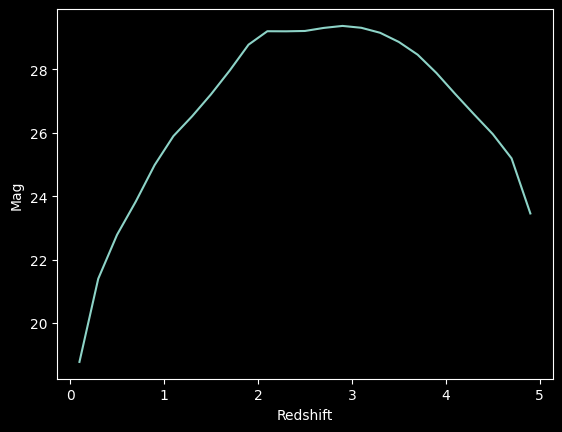

In [15]:
plt.plot(df['Redshift'].to_numpy(),df['sdss_i'].to_numpy())
plt.xlabel("Redshift")
plt.ylabel("Mag");

In [ ]:
from astropy.cosmology import Planck18 as cosmo

# Compute the age of the universe at redshift 10
age_at_z10 = cosmo.age(10).value  # in Gyr

# Compute the age of the universe at redshift 0.5
age_at_z11 = cosmo.age(11).value  # in Gyr

print(f"Age of the universe at redshift 10: {age_at_z10:.2f} Gyr") #when we're observing it
print(f"Age of the universe at redshift 11: {age_at_z11:.2f} Gyr") #when it was born

Age of the universe at redshift 10: 0.47 Gyr
Age of the universe at redshift 11: 0.41 Gyr
